In [ ]:
#import shap
#shap.initjs()

In [ ]:
# used

#pip install C:/Users/vvlachou/Desktop/AML/Packages/xgboost-1.5.2.tar.gz
#pip install C:/Users/vvlachou/Desktop/AML/Packages/xgboost-1.5.2-py3-none-win_amd64.whl

In [1]:
#pd.set_option('display.max_rows', None)

from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import pyodbc
import warnings
warnings.filterwarnings("ignore")

In [2]:
data_x = pd.read_csv('X.txt',delimiter = ";")
data_y = pd.read_csv('y.txt',delimiter = ";")

In [3]:
[str(x) for x in data_x.columns if data_x[x].dtypes == 'object']

['EBA_Priority_Segment',
 'Gender',
 'Education',
 'Marital_Status',
 'Age_Band',
 'GS_Segment',
 'Consumer_Segment',
 'Income_Segment',
 'LifeStage_Segment']

In [4]:
for col in data_x.columns[1:-1]:       
       if data_x[col].dtype =='object': 
            data_x = pd.get_dummies(data_x, prefix=col + '_', columns=[col])
            
df_x = data_x.drop(columns = ['Customer_id', 'Checks_Issued_Last_1Y_MaxAmount'])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df_x, data_y, test_size = 0.30, random_state = 42)

In [6]:
import gc

del [[df_x, data_x]]
gc.collect()

0

In [7]:
def undersampling(training_data, training_target, bad_prc = 0.25, prints = False):

    bad_cases = training_target.loc[training_target == 1]
    good_cases = training_target.loc[training_target != 1]

    x_bad = training_data.iloc[bad_cases.index]

    good_cases_per_sample = int(((1 - bad_prc) * len(bad_cases)) // bad_prc)

    sample = good_cases.sample(good_cases_per_sample, replace = False, random_state = 42)

    y_resampled = pd.concat([bad_cases, sample], axis=0)

    x_resampled = pd.concat([x_bad, training_data.loc[sample.index, :]], axis=0)

    if prints:

        # Plot the distribution in the undersampled dataset
        display(pd.DataFrame(round(y_resampled.value_counts(normalize=True) * 100, 1).astype(str) + '%').rename(index={0: 'Good', 1: 'Bad'}, columns={'status': 'Undersampled'}))

    return x_resampled, y_resampled

num_classes = 2

In [8]:
X_training, y_training = X_train.reset_index(drop = True), y_train.reset_index(drop = True)

y_training = y_training.fillna(0)
y_test = y_test.fillna(0)

In [ ]:
x_undersampled, y_undersampled = undersampling(X_training, y_training['Primary_Bank_y'], bad_prc = 0.25, prints = True)

In [ ]:
# Training Dataset
x_undersampled, y_undersampled
X_test, y_test

## Logistic Regression

### Ridge Regression (L2)

In [9]:
from sklearn.linear_model import LogisticRegression
#from sklearn import metrics

def logistic_regression_model(train_x, test_x, train_y, penalty='l2', solver='lbfgs', l1_ratio=None):
    model = LogisticRegression(penalty=penalty, solver=solver, l1_ratio=l1_ratio)
    model.fit(train_x, train_y)
    y_predicted = model.predict(test_x)
    probabilities = model.predict_proba(test_x)
    return model, y_predicted, probabilities

Calculate metrics

In [31]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def calculate_model_metrics(model, test_x, test_y, pred_y, model_name='Logistic Regression', prints = False):
    accuracy = model.score(test_x, test_y)
    f1 = f1_score(y_test, pred_y, average="macro")
    precision = precision_score(y_test, pred_y, average="macro")
    recall = recall_score(y_test, pred_y, average="macro")
    cm = confusion_matrix(y_test, y_pred, normalize='all')
    
    if prints:
        print('Accuracy of %s classifier on test set: {:.2f}'.format(accuracy) % model_name)
        print("F1 Score: ", f1)
        print("Precision Score: ", precision)
        print("Recall Score: ", recall)
        ConfusionMatrixDisplay(cm, display_labels=model.classes_).plot(cmap = plt.cm.Blues)
        
        plt.title(label='Confusion Matrix', fontweight=15)
        
    return accuracy, f1, precision, recall, cm

Calculate roc auc

In [11]:
from sklearn.metrics import roc_curve, roc_auc_score

def calculate_plot_roc_auc(test_y, probabilities, model='Logistic'):
    
    ns_probs = [0 for _ in range(len(y_test))]
    lr_probs = probabilities[:, 1]
    
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('%s: ROC AUC=%.3f' % (model, lr_auc))
    
    ns_fpr, ns_tpr, _ = roc_curve(test_y, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(test_y, lr_probs)
    
    plt.figure(figsize =(15, 10))
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='%s' % model)
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

Calculate important features

In [35]:
import operator

def calculate_plot_important_features(model, train_x, title_model = 'Logistic Regression'):
    
    important_features = {}
    
    importance = model.coef_[0]
    for feat, importance in zip(train_x.columns, importance):
        important_features[feat] = importance
        
    important_features_df = pd.DataFrame(sorted(important_features.items(), key=operator.itemgetter(1), reverse=True), 
                                     columns=['Feature', 'Importance'])
    
    fig, ax = plt.subplots(figsize =(25, 20))
 
    # Horizontal Bar Plot
    ax.barh(important_features_df['Feature'].head(10), important_features_df['Importance'].head(10))

    # Remove x, y Ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')


    # Add padding between axes and labels
    ax.xaxis.set_tick_params(pad = 5, labelsize = '15')
    ax.yaxis.set_tick_params(pad = 20, labelsize = '15')


    # Add x, y gridlines
    ax.grid(b = True, color ='grey',
            linestyle ='-.', linewidth = 0.5,
            alpha = 0.2)


    # Show top values
    ax.invert_yaxis()


    # Add annotation to bars
    for i in ax.patches:
        plt.text(i.get_width(), i.get_y()+0.5,
                 str("{:.6f}".format(float(i.get_width()))),
                 fontsize = 15, fontweight ='bold',
                 color ='grey')

    # Add Plot Title
    ax.set_title('%s Feature Importance' % title_model,
                 loc ='center', fontsize = 15 )

    # Show Plot
    plt.show()

### Logistic regression w/no penalty

In [14]:
x_undersampled, y_undersampled = undersampling(X_training, y_training['Primary_Bank_y'], bad_prc = 0.25, prints = True)

model, y_pred, probas = logistic_regression_model(x_undersampled, X_test, y_undersampled)

,Primary_Bank_y
Good,75.0%
Bad,25.0%


In [15]:
accuracy, f1, precision, recall, cm = calculate_model_metrics(model, X_test, y_test, y_pred, True)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.811


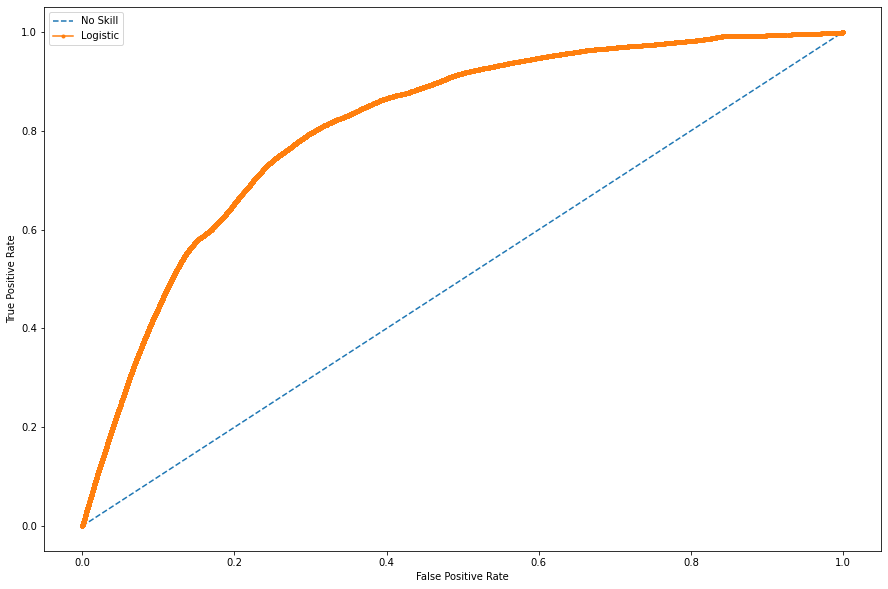

In [16]:
calculate_plot_roc_auc(y_test, probas)

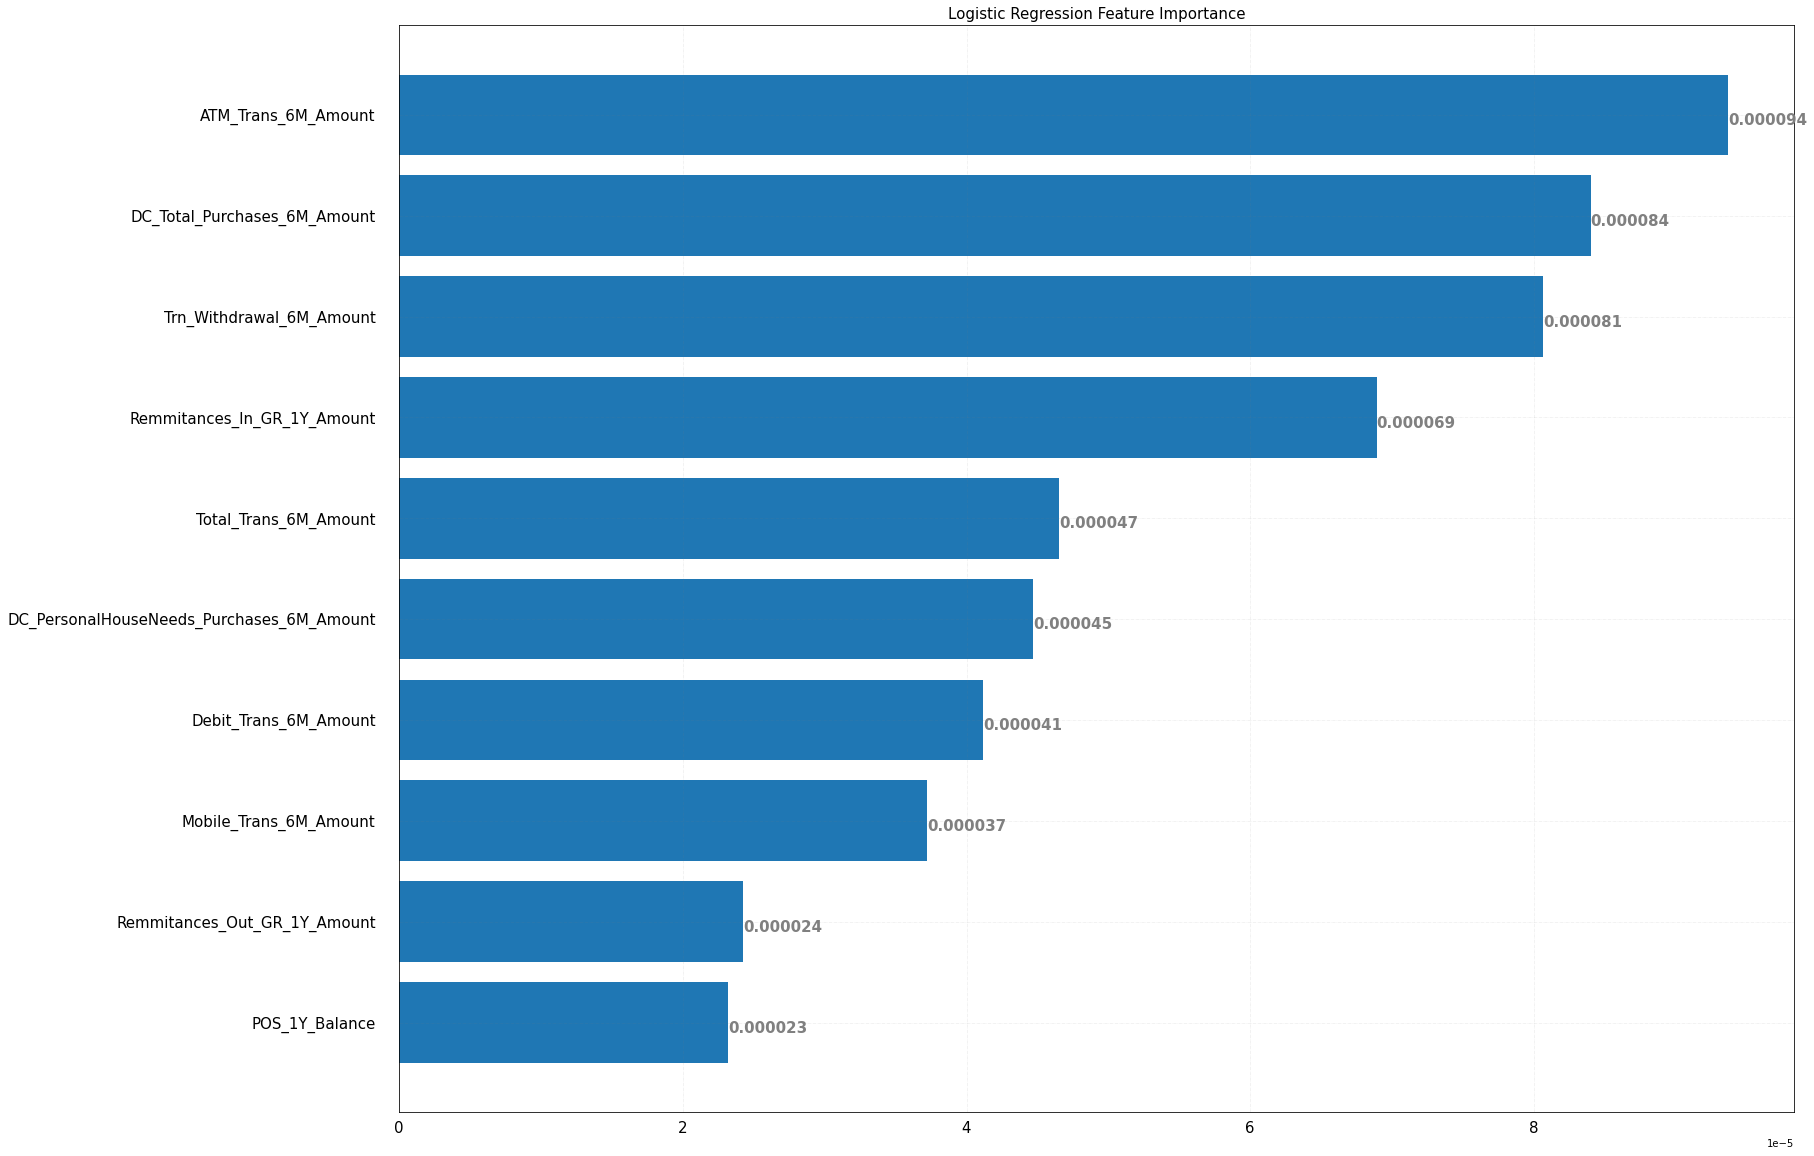

In [36]:
calculate_plot_important_features(model, X_train)

### Lasso (L1)

In [ ]:
model_lasso, y_pred_lasso, probas_lasso = logistic_regression_model(x_undersampled, X_test, y_undersampled, 
                                                                    penalty='l1', solver = 'saga')

In [ ]:
accuracy_lasso, f1_lasso, precision_lasso, recall_lasso, cm_lasso = calculate_model_metrics(model_lasso, X_test, y_test, y_pred, True)

In [ ]:
calculate_plot_roc_auc(y_test, probas_lasso)

In [ ]:
calculate_plot_important_features(model_lasso, X_train)

### Elasticnet (Both L1 and L2)

In [ ]:
model_elasticnet, y_pred_elasticnet, probas_elasticnet = logistic_regression_model(x_undersampled, X_test, y_undersampled, 
                                                                    penalty='elasticnet', solver = 'saga', l1_ratio =0.3)

In [ ]:
accuracy_elasticnet, f1_elasticnet, precision_elasticnet, recall_elasticnet, cm_elasticnet = calculate_model_metrics(model, X_test, y_test, y_pred_elasticnet, True)

In [ ]:
calculate_plot_roc_auc(y_test, probas_elasticnet)

In [ ]:
calculate_plot_important_features(model_elasticnet, X_train)

### Decision Tree Classifier

In [40]:
from sklearn.tree import DecisionTreeClassifier

model_tree = DecisionTreeClassifier(criterion="entropy", max_depth=3);

In [41]:
model_tree.fit(x_undersampled, y_undersampled)
pred_tree = model_tree.predict(X_test)
proba_tree = model_tree.predict_proba(X_test)

Accuracy of Decision Tree classifier on test set: 0.86
F1 Score:  0.6289700285086285
Precision Score:  0.6014802721577197
Recall Score:  0.8041011744955228


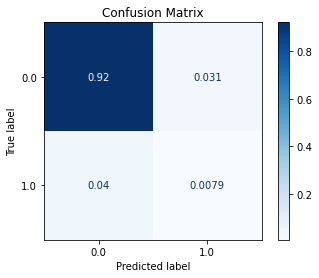

In [42]:
accuracy_tree, f1_tree, precision_tree, recall_tree, cm_tree = calculate_model_metrics(model_tree, X_test, y_test, pred_tree, 'Decision Tree', True)

No Skill: ROC AUC=0.500
Decision Tree: ROC AUC=0.869


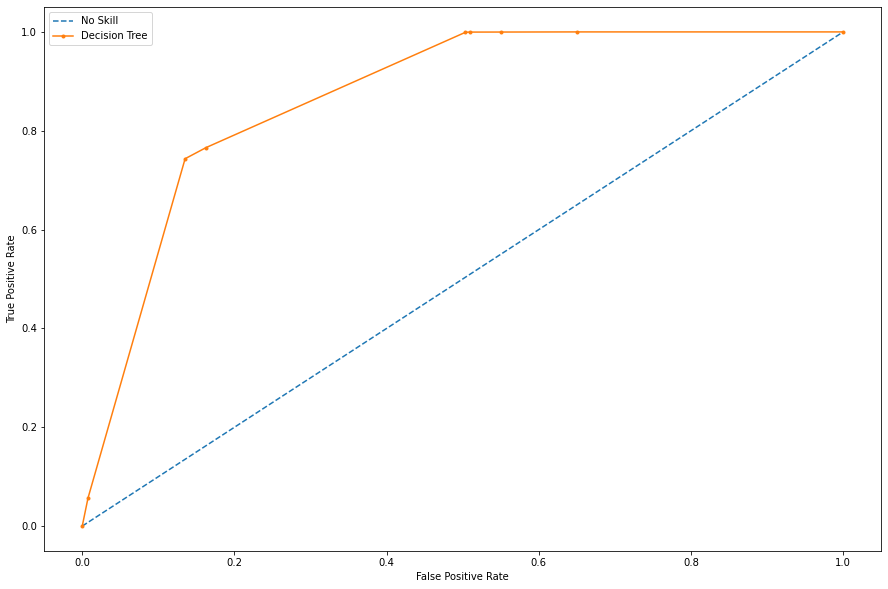

In [43]:
calculate_plot_roc_auc(y_test, proba_tree, 'Decision Tree')

In [38]:
from sklearn.tree import export_graphviz

### Random Forest

In [ ]:
from hyperopt import tpe, hp, fmin, STATUS_OK,Trials
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler()
X_scaled = scaler.fit_transform(x_undersampled)

In [ ]:
space = {
    "n_estimators": hp.choice("n_estimators", [100, 200, 300, 400,500,600]),
    "max_depth": hp.quniform("max_depth", 1, 15,1),
    "criterion": hp.choice("criterion", ["gini", "entropy"]),
}

In [ ]:
def hyperparameter_tuning(params):
    clf = RandomForestClassifier(**params,n_jobs=-1)
    acc = cross_val_score(clf, X_scaled, y_undersampled,scoring="accuracy").mean()
    return {"loss": -acc, "status": STATUS_OK}

In [ ]:
trials = Trials()

best = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=100, 
    trials=trials
)

print("Best: {}".format(best))

In [ ]:
model_random_forest = RandomForestClassifier(n_estimators = 600, criterion = 'gini', max_depth = 15 ,n_jobs=-1)
model_random_forest.fit(x_undersampled, y_undersampled)

In [ ]:
X_test_transformed = scaler.transform(X_test)
y_pred = model_random_forest.predict(X_test_transformed)

In [ ]:
probabilities_random_forest = model_random_forest.predict_proba(X_test_transformed)

In [ ]:
accuracy, f1, precision, recall, cm = calculate_model_metrics(model_random_forest, X_test_transformed, y_test, y_pred, 
                                                              'Random Forest', True)

In [ ]:
calculate_plot_roc_auc(y_test, probabilities_random_forest, 'Random Forest')

### XGBoost

In [19]:
from hyperopt import Trials, fmin, tpe, space_eval, STATUS_OK, hp
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

In [10]:
space = {
    "n_estimators": hp.choice("n_estimators", [100, 200, 300, 400,500,600]),
    "max_depth": hp.choice("max_depth", np.arange(1,20)),
    "learning_rate": hp.choice("learning_rate", np.round(np.arange(0.1, 1, 0.1), 2)),
    "reg_alpha": hp.choice("reg_alpha", np.arange(30,1000,50))
}

In [15]:
from sklearn.model_selection import StratifiedKFold

def hyperparameter_tuning(training_data, training_target, scoring_metric, bad_prc = 0.25):
    
    def objective(params):
    
        cv_scores = []
        
        print('Params testing: ', params)
        print('\n ')

        cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)

        for train, val in cv.split(training_data, training_target):
        
            x_temp, y_temp = training_data.iloc[train].reset_index(drop = True), training_target.iloc[train].reset_index(drop = True)

            x_undersampled, y_undersampled = undersampling(x_temp, y_temp, bad_prc)

            model_xgboost = XGBClassifier(**params, n_jobs=-1)
            model_xgboost.fit(x_undersampled, y_undersampled)
            
            predictions = model_xgboost.predict(training_data.iloc[val])

            if scoring_metric == 'roc_auc': 
                metric = roc_auc_score(training_target.iloc[val], predictions)
            else: 
                metric = average_precision_score(training_target.iloc[val], predictions)

            cv_scores.append(metric)

        loss = 1 - np.mean(cv_scores)
        
        return {'loss': loss, 'status': STATUS_OK}

    return objective

In [16]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_training), columns = X_training.columns.str.replace("<", "."))

objective = hyperparameter_tuning(X_scaled, y_training['Primary_Bank_y'], scoring_metric = 'roc_auc', bad_prc = 0.25)

In [13]:
from hyperopt.plotting import main_plot_history

def select_parameters(objective_function, parameter_space, max_evals, prints = True):

    trials = Trials()

    best_indices = fmin(objective_function,
                        parameter_space,
                        algo=tpe.suggest,
                        trials=trials,
                        max_evals=max_evals,
                        rstate=np.random.default_rng(42))

    best_parameters = space_eval(parameter_space, trials.argmin)

    if prints:
        print('Best params are:')
        print(best_parameters)

        #main_plot_history(trials)  

    return best_parameters, best_indices, trials

In [20]:
params, indices, trials = select_parameters(objective, space, 10, prints = True)

Params testing:                                                                                                        
{'learning_rate': 0.6, 'max_depth': 13, 'n_estimators': 500, 'reg_alpha': 30}                                          
[13:07:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
This is the model:                                                                                                     
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,                                                   
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.6, max_delta_ste

This is the model:                                                                                                     
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,                                                   
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.6, max_delta_step=0,
              max_depth=13, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=30, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
[15:18:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logis

[16:13:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
This is the model:                                                                                                     
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,                                                   
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=130, reg_lam

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,                                                   
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=630, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
[16:47:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
This i

job exception: Unable to allocate 3.36 GiB for an array with shape (312, 1443987) and data type float64



 40%|████████████████▊                         | 4/10 [3:55:31<5:53:17, 3532.88s/trial, best loss: 0.13770133300581322]


MemoryError: Unable to allocate 3.36 GiB for an array with shape (312, 1443987) and data type float64

In [ ]:
objective

In [22]:
len(X_train)

1604430